# Test of battery self depletion with OpenUPS

## Methodology

A RC 4S 6000mAh LiPo battery is plugged to the OpenUPS board. The board is plugged to a computer to USB, and is turned off (no output). Every hours a script is querying the state of the OpenUPS and store them in a text file.

## Results

### Code to extract data from report file

The function below extract the temperature and cell voltage value from each status report file and sort them

In [1]:
from glob import glob
from pathlib import Path
from datetime import datetime
import pandas as pd

def extract_data():
    df = pd.DataFrame(
        columns=["date", "temperature", "cell1", "cell2", "cell3", "cell4"]
    )
    for i, filepath in enumerate(glob("./data/*.txt")):
        date = datetime.strptime(Path(filepath).stem, "%Y%m%dT%H:%M:%S.%f%z")
        temperature = None
        vcell = [0] * 6
        with open(filepath, "r") as f:
            for l in f.readlines():
                if l.startswith("Temperature: "):
                    temperature = float(l.removeprefix("Temperature: "))
                if l.startswith(" VCell"):
                    idx = int(l.removeprefix(" VCell")[:1]) - 1
                    value = float(l[9:])
                    if idx < 6:
                        vcell[idx] = value
            df.loc[i] = [date, temperature] + vcell[2:]
    return df.sort_values('date')


In [2]:
data = extract_data()
data

,date,temperature,cell1,cell2,cell3,cell4
27,2024-07-01 14:25:15+02:00,25.0,3.88221,3.89078,3.89078,3.89078
110,2024-07-01 15:00:01+02:00,26.0,3.88221,3.89078,3.89078,3.89078
215,2024-07-01 16:00:01+02:00,27.0,3.88221,3.89078,3.89078,3.89078
87,2024-07-01 17:00:01+02:00,27.0,3.88221,3.89078,3.88221,3.89078
198,2024-07-01 18:00:01+02:00,27.0,3.88221,3.89078,3.88221,3.89078
...,...,...,...,...,...,...
186,2024-07-11 07:00:01+02:00,28.0,3.87364,3.88221,3.88221,3.89078
157,2024-07-11 08:00:01+02:00,28.0,3.87364,3.88221,3.88221,3.89078
169,2024-07-11 09:00:01+02:00,28.0,3.87364,3.88221,3.88221,3.89078
180,2024-07-11 10:00:01+02:00,28.0,3.87364,3.88221,3.88221,3.89078


Now we plot the cell self-depletion overtime and their temperature

<Axes: xlabel='date'>

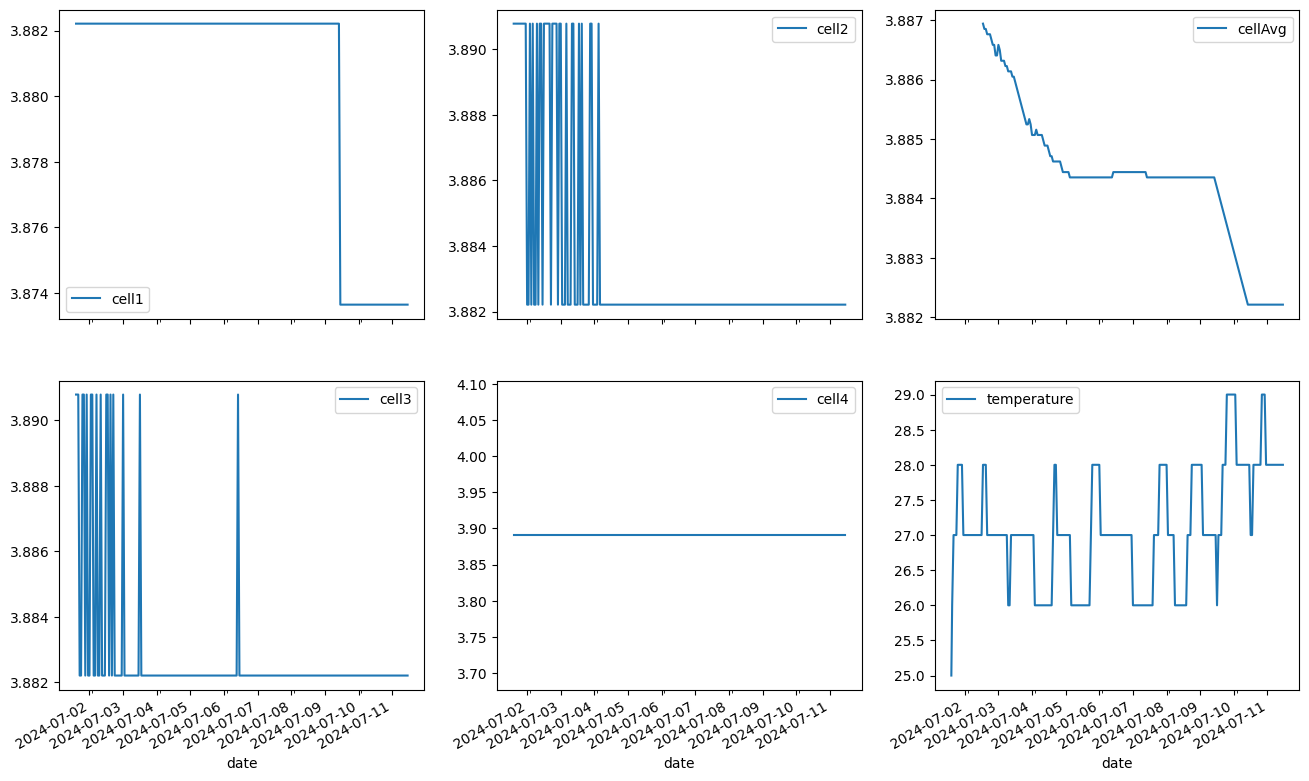

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(16,10),sharex=True)
# Compute the moving average value of the cell on a window of 24h
data['cellAvg'] = data[[f'cell{i+1}' for i in range(4)]].mean(axis=1).rolling(24).mean()
data.plot(x='date',y='cell1',ax=axes[0,0])
data.plot(x='date',y='cell2',ax=axes[0,1])
data.plot(x='date',y='cell3',ax=axes[1,0])
data.plot(x='date',y='cell4',ax=axes[1,1])
data.plot(x='date',y='cellAvg',ax=axes[0,2])
data.plot(x='date',y='temperature',ax=axes[1,2])

Now we can compute the experimental maximum drop rate of a cell over the entire duration of the experiment. We can estimate the time it is safe to leave the battery plugged after:
* A force shutdown event: the system is configured to turn off at 3.5V, therefore with a margin of 250mV the cells are still safe to use (3.25V)
* After leaving to a storage charge of 25% (~3.8V). with a margin of 550mv, the cells will still be safe to use.

In [7]:

delta = data.iloc[-1] - data.iloc[0]
print(delta)
deltaT = delta['date']
maxCell= delta[[f'cell{i+1}' for i in range(4)]].min()
dropPerDay = maxCell * 1000 * 3600 * 24 / deltaT.total_seconds()
print(f'duration: {deltaT}, maxCell drop: {maxCell* 1000:.2f} mV, rate: {dropPerDay:.2f} mV/24h')

def printMargin(margin):
    safeDuration = -margin / dropPerDay
    print(f"Assuming a safety margin of {margin}mV, it is safe to leave the battery plugged {safeDuration:.1f} days")

printMargin(250)
printMargin(550)

date           9 days 20:34:46
temperature                3.0
cell1                 -0.00857
cell2                 -0.00857
cell3                 -0.00857
cell4                      0.0
cellAvg                    NaN
dtype: object
duration: 9 days 20:34:46, maxCell drop: -8.57 mV, rate: -0.87 mV/24h
Assuming a safety margin of 250mV, it is safe to leave the battery plugged 287.6 days
Assuming a safety margin of 550mV, it is safe to leave the battery plugged 632.6 days
